In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [5]:
# Load the training data
train_path = "/content/train_data.txt"
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')

In [6]:
# Display basic information about the training data
print(train_data.describe())
print(train_data.info())
print(train_data.isnull().sum())

                                 Title    Genre  \
count                            54214    54214   
unique                           54214       27   
top      Oscar et la dame rose (2009)    drama    
freq                                 1    13613   

                                              Description  
count                                               54214  
unique                                              54086  
top      Grammy - music award of the American academy ...  
freq                                                   12  
<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None
Title          0
Genre          0
Description    0
dtype: int64


In [7]:
# Load the test data
test_path = "/content/test_data.txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_data.head()


,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


<ipython-input-8-bca75ad896ae>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, y='Genre', order=train_data['Genre'].value_counts().index, palette='viridis')


Text(0, 0.5, 'Genre')

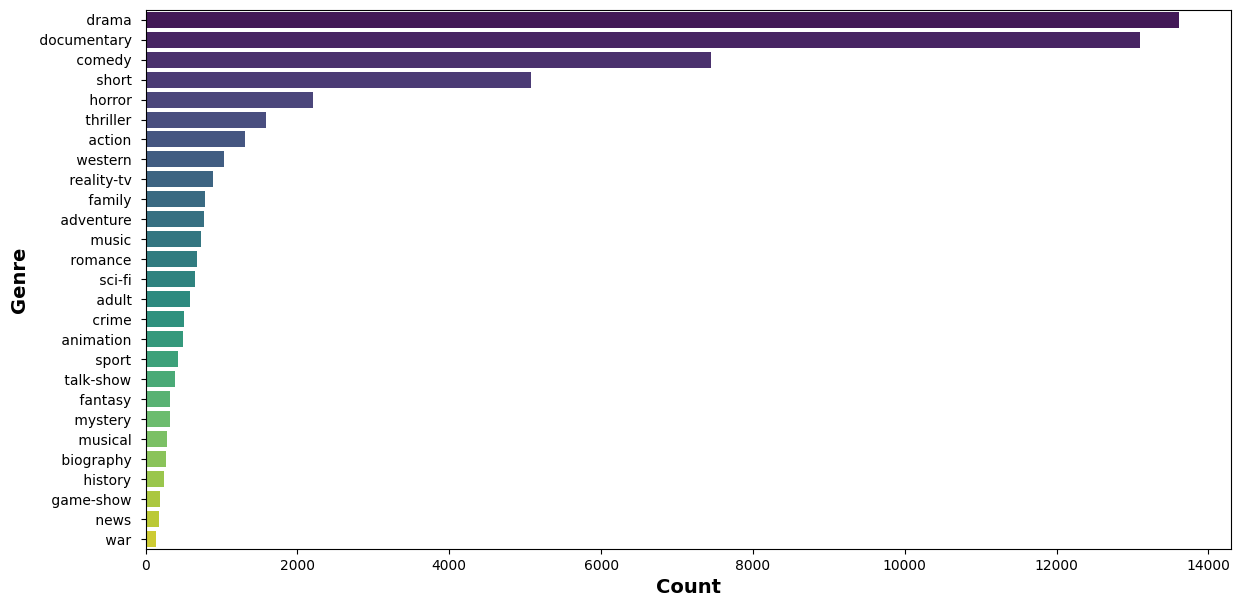

In [8]:
# Plot the distribution of genres in the training data
plt.figure(figsize=(14, 7))
sns.countplot(data=train_data, y='Genre', order=train_data['Genre'].value_counts().index, palette='viridis')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Genre', fontsize=14, fontweight='bold')

<ipython-input-9-5f4a6038ff70>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette='coolwarm')


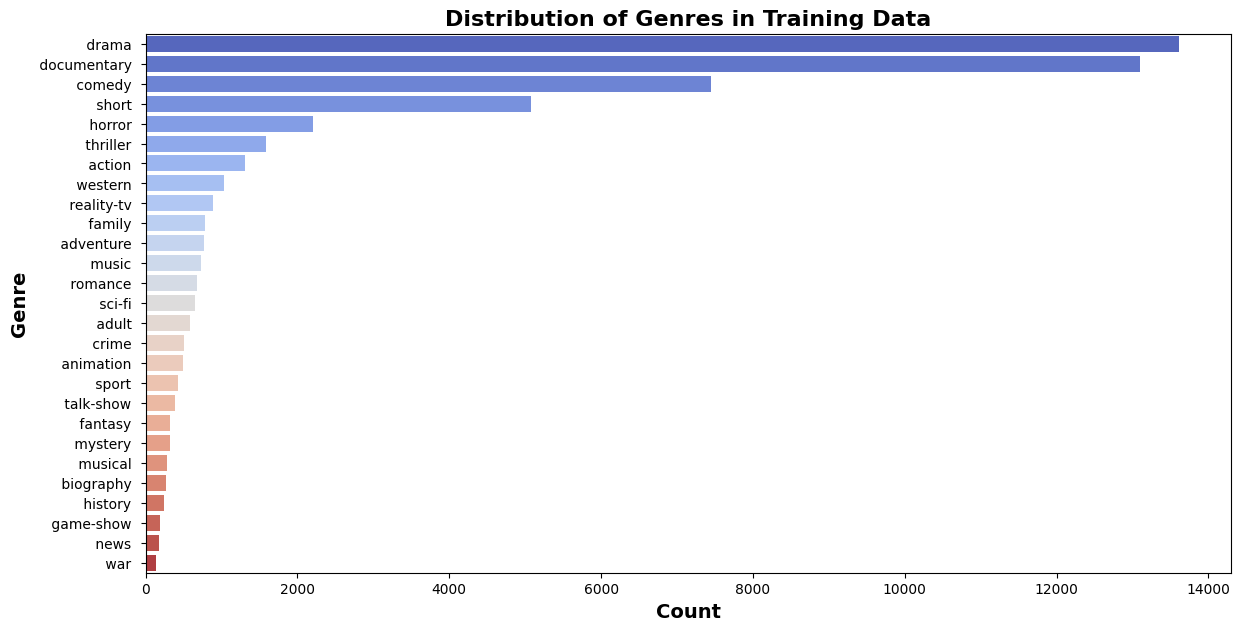

In [9]:
# Plot the distribution of genres using a horizontal bar plot
plt.figure(figsize=(14, 7))
counts = train_data['Genre'].value_counts()
sns.barplot(x=counts.values, y=counts.index, palette='coolwarm')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Genre', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres in Training Data', fontsize=16, fontweight='bold')
plt.show()

In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Initialize the stemmer and custom stop words list
stemmer = LancasterStemmer()
custom_stop_words = set(stopwords.words('english')).union({'movie', 'film', 'plot'})

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\w+', '', text)  # Remove Twitter handles
    text = re.sub(r'http[s]?://\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\W+', ' ', text)  # Keep only alphabetic characters and spaces
    text = re.sub(r'\b\w\b', '', text)  # Remove single characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = nltk.word_tokenize(text)
    text = " ".join([stemmer.stem(word) for word in words if word not in custom_stop_words])
    return text

In [12]:
# Apply the clean_text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

In [13]:
# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)
test_data['length_Text_cleaning'] = test_data['Text_cleaning'].apply(len)

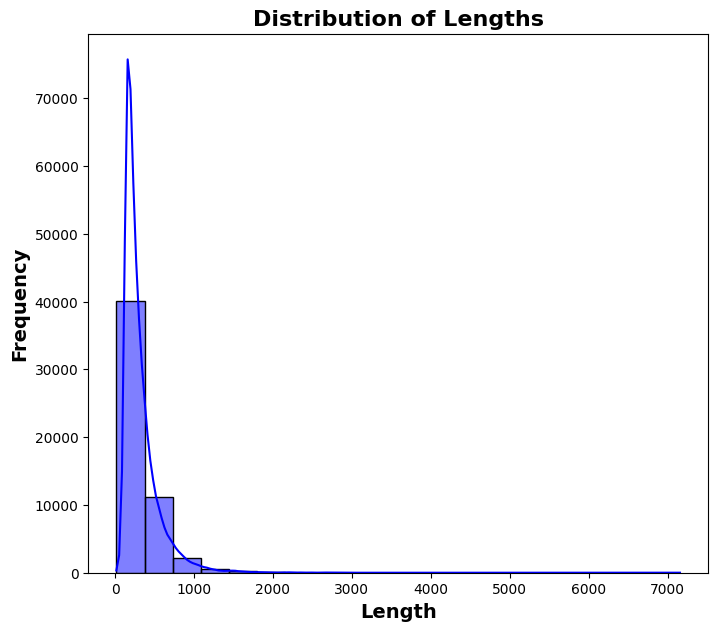

In [14]:
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

In [15]:
# Initialize the TF-IDF vectorizer with different parameters
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')

In [16]:
# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

In [17]:
# Transform the test data
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

In [18]:
# Split the data into training and validation sets with a different ratio
X = X_train
y = train_data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=123)

In [19]:
# Initialize and train a Logistic Regression classifier
classifier = LogisticRegression(max_iter=200, solver='liblinear', random_state=123)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=123, solver='liblinear')

In [20]:
# Make predictions on the validation set
y_pred = classifier.predict(X_val)

In [21]:
# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.5692046628301608


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.53      0.27      0.36       317
       adult        0.71      0.21      0.32       146
   adventure        0.61      0.12      0.20       184
   animation        0.36      0.04      0.07       121
   biography        0.00      0.00      0.00        65
      comedy        0.50      0.56      0.53      1838
       crime        0.20      0.01      0.01       138
 documentary        0.64      0.86      0.73      3277
       drama        0.52      0.77      0.62      3420
      family        0.54      0.07      0.12       196
     fantasy        0.00      0.00      0.00        90
   game-show        0.94      0.56      0.70        55
     history        0.00      0.00      0.00        71
      horror        0.67      0.58      0.62       536
       music        0.66      0.38      0.49       169
     musical        1.00      0.01      0.02        80
     mystery        0.00      0.00      0.00        72
        n

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Use the trained model to make predictions on the test data
X_test_predictions = classifier.predict(X_test)
test_data['Predicted_Genre'] = X_test_predictions

In [23]:
# Save the test_data DataFrame with predicted genres to a CSV file with a different name
test_data.to_csv('movie_genre_predictions.csv', index=False)

In [24]:
# Display the 'test_data' DataFrame with predicted genres
print(test_data)

          Id                             Title  \
0          1             Edgar's Lunch (1998)    
1          2         La guerra de papá (1977)    
2          3      Off the Beaten Track (2010)    
3          4           Meu Amigo Hindu (2015)    
4          5                Er nu zhai (1955)    
...      ...                               ...   
54195  54196   "Tales of Light & Dark" (2013)    
54196  54197      Der letzte Mohikaner (1965)    
54197  54198              Oliver Twink (2007)    
54198  54199                Slipstream (1973)    
54199  54200        Curitiba Zero Grau (2010)    

                                             Description  \
0       L.R. Brane loves his life - his car, his apar...   
1       Spain, March 1964: Quico is a very naughty ch...   
2       One year in the life of Albin and his family ...   
3       His father has died, he hasn't spoken with hi...   
4       Before he was known internationally as a mart...   
...                                    